# Введение

Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

Мы располагаем данными о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

Изучим следующее:
* откуда приходят пользователи и какими устройствами они пользуются.
* сколько стоит привлечение пользователей из различных рекламных каналов.
* сколько денег приносит каждый клиент.
* когда расходы на привлечение клиента окупаются.
* какие факторы мешают привлечению клиентов.

# Данные

В нашем распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

**Структура visits_info_short.csv:**
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

**Структура orders_info_short.csv:**
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

**Структура costs_info_short.csv:**
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

# Ход работы

### Загрузим данные и подготовьте их к анализу

Загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные.

**Пути к файлам**

- визиты: `/datasets/visits_info_short.csv`. 
- заказы: `/datasets/orders_info_short.csv`. 
- расходы: `/datasets/costs_info_short.csv`.

Изучим данные и выполним предобработк: 
* Оценим данные на наличие пропусков и дубликатов
* Убедимся, что типы данных во всех колонках соответствуют сохранённым в них значениям. 
* Обратим внимание на столбцы с датой и временем.

**Импортируем необходимые библиотеки**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
from datetime import date, datetime, timedelta
from IPython.core.display import display, HTML

In [2]:
import warnings
warnings.filterwarnings("ignore")

**Импортируем нализируемые датасеты**

In [3]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

Создадим удобную функцию для вывода информации:

In [4]:
def info(entry):
    print('ОБЩИЙ ВИД')
    print(entry, '\n ')
    print('ТИПЫ ДАННЫХ')
    print(entry.info(), '\n ')
    print('СТАТИСТИКА')
    print(entry.describe(), '\n ')
    print('ПРОПУСКИ В ДАННЫХ')
    print(visits.isna().sum(), '\n ')
    print('ДУБЛИКАТОВ: ', visits.duplicated().sum())

#### Проанализируем датафрейм visits

In [5]:
info(visits)

ОБЩИЙ ВИД
             User Id         Region   Device         Channel  \
0       981449118918  United States   iPhone         organic   
1       278965908054  United States   iPhone         organic   
2       590706206550  United States      Mac         organic   
3       326433527971  United States  Android          TipTop   
4       349773784594  United States      Mac         organic   
...              ...            ...      ...             ...   
309896  329994900775             UK       PC         LeapBob   
309897  334903592310         France       PC  lambdaMediaAds   
309898  540102010126        Germany       PC         organic   
309899  308736936846        Germany      Mac         organic   
309900  109329042535        Germany       PC  lambdaMediaAds   

              Session Start          Session End  
0       2019-05-01 02:36:01  2019-05-01 02:45:01  
1       2019-05-01 04:46:31  2019-05-01 04:47:35  
2       2019-05-01 14:09:25  2019-05-01 15:32:08  
3       2019-05-0

**ПОДЫТОГ ПО ДАТАСЕТУ VISITS**

* Дубликатов нет
* Пропусков нет
* Названия столбцов не в snace_case
* Session Start и Session End имеют тип Object, а не DateTime

Приведем все столбцы к змеинному регистру. Изменим тип данных на DateTime где необходимо.

In [6]:
visits.columns = map(str.lower, visits.columns)
visits.columns = visits.columns.str.replace(' ','_')
visits['session_start'] = pd.to_datetime(visits['session_start'], format = '%Y-%m-%d %H:%M:%S')
visits['session_end'] = pd.to_datetime(visits['session_end'], format = '%Y-%m-%d %H:%M:%S')

#### Проанализируем датафрейм Orders

In [7]:
info(orders)

ОБЩИЙ ВИД
            User Id             Event Dt  Revenue
0      188246423999  2019-05-01 23:09:52     4.99
1      174361394180  2019-05-01 12:24:04     4.99
2      529610067795  2019-05-01 11:34:04     4.99
3      319939546352  2019-05-01 15:34:40     4.99
4      366000285810  2019-05-01 13:59:51     4.99
...             ...                  ...      ...
40207  651604369137  2019-10-31 16:19:07     4.99
40208  275341387049  2019-10-31 01:17:17     4.99
40209  374656616484  2019-10-31 06:17:29     4.99
40210  168548862926  2019-10-31 22:46:19     4.99
40211  329994900775  2019-10-31 13:29:06     4.99

[40212 rows x 3 columns] 
 
ТИПЫ ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory

ПОДЫТОГ ПО ДАТАСЕТУ ORDERS

* Дубликатов нет
* Пропусков нет
* Названия столбцов не в snace_case
* Event DT имеет тип Object, а не DateTime

Приведем все столбцы к змеинному регистру. Изменим тип данных на DateTime где необходимо.

In [8]:
orders.columns = map(str.lower, orders.columns)
orders.columns = orders.columns.str.replace(' ','_')
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format = '%Y-%m-%d %H:%M:%S')

#### Проанализируем датафрейм Costs

In [9]:
info(costs)

ОБЩИЙ ВИД
              dt         Channel  costs
0     2019-05-01        FaceBoom  113.3
1     2019-05-02        FaceBoom   78.1
2     2019-05-03        FaceBoom   85.8
3     2019-05-04        FaceBoom  136.4
4     2019-05-05        FaceBoom  122.1
...          ...             ...    ...
1795  2019-10-23  lambdaMediaAds    4.0
1796  2019-10-24  lambdaMediaAds    6.4
1797  2019-10-25  lambdaMediaAds    8.8
1798  2019-10-26  lambdaMediaAds    8.8
1799  2019-10-27  lambdaMediaAds   12.0

[1800 rows x 3 columns] 
 
ТИПЫ ДАННЫХ
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB
None 
 
СТАТИСТИКА
             costs
count  1800.000000
mean     58.609611
std     107.740223
min       0.800000
25%    

ПОДЫТОГ ПО ДАТАСЕТУ COSTS

* Дубликатов нет
* Пропусков нет
* Названия столбцов не в snace_case
* dt имеет тип Object, а не DateTime

Приведем все столбцы к змеинному регистру. Изменим тип данных на DateTime где необходимо.

In [10]:
costs.columns = map(str.lower, costs.columns)
costs.columns = costs.columns.str.replace(' ','_')
costs['dt'] = pd.to_datetime(costs['dt'], format = '%Y-%m-%d %H:%M:%S')

Как можно заметить - во всех трех датафремах были одни и те же проблеммы. Мы их решили и на этом этап предобработки данных можно считать завершенным.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Зададим необходимые функции:

Для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [11]:
# ФУНКЦИЯ ДЛЯ СОЗДАНИЯ ПОЛЬЗОВАТЕЛЬСКИХ ПРОФИЛЕЙ

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'], format="%Y-%m-%d")
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())


    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [12]:
#ФУНКЦИЯ ДЛЯ РАСЧЕТА УДЕРЖАНИЯ
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [13]:
#ФУНКЦИЯ ДЛЯ РАСЧЕТА КОНВЕРСИИ

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [14]:
#ФУНКЦИЯ РАСЧЕТА LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [15]:
#ФУНКЦИЯ ОДНОВРЕМЕННОГО ВЫЗОВА LTV+ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [16]:
#ФИЛЬТР ДАННЫХ

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [17]:
#ВИЗУАЛИЗАЦИЯ УДЕРЖАНИЯ

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [18]:
#ВИЗУАЛИЗАЦИЯ КОНВЕРСИИ

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(10, 3))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [19]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(15, 8))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных

#### Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.

In [20]:
profiles = get_profiles(visits, orders, costs)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [21]:
print('Минимальная дата привлечения пользователей: ', profiles['dt'].min())
print('Максимаьная дата привлечения пользователей: ', profiles['dt'].max())

Минимальная дата привлечения пользователей:  2019-05-01 00:00:00
Максимаьная дата привлечения пользователей:  2019-10-27 00:00:00


Полученные данные подтверждают информацию, предоставленную заказчиком. Действительно, данные для анализа были собраны за период с 1 мая по 27 октября 2019 года

#### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.
Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [22]:
rega = profiles.groupby('region').agg({'user_id':'nunique', 'payer':'sum'}).sort_values(by = ['user_id'],ascending = False)
rega['conversion'] = rega['payer'] / rega['user_id']
rega

,user_id,payer,conversion
region,,,
United States,100002,6902,0.069019
UK,17575,700,0.039829
France,17450,663,0.037994
Germany,14981,616,0.041119


- Доминирующее количество платящих клиентов сосредоточено в США. 
- Доминирующее число платящих клиентов сосредоточено в США.
- Остальные платящие клменты очень равномерно распределены по трем крупнейшим странам Западной Европы: Франции, Германии и 

#### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. 
Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [23]:
devicer = profiles.groupby('device').agg({'payer' : 'sum', 'device' : 'count'}).sort_values(by='payer', ascending=False)
devicer['payers_share (%)'] = (devicer['payer']/devicer['payer'].sum())*100
devicer

,payer,device,payers_share (%)
device,,,
iPhone,3382,54479,38.081297
Android,2050,35032,23.082986
Mac,1912,30042,21.529107
PC,1537,30455,17.306610


Согласно данным, большинство платящих пользователей приходится на мобильные платформы. Следовательно, при маркетинге стоит делать упор на рекламу в мобильных приложениях и учитывать специфику рекламы для мобильных устройств. При том отмечается, что больше всего платящих пользователей среди тех, кто владеет техникой Apple

#### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. 
Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [24]:
source = profiles.groupby('channel').agg({'payer' : 'sum', 'device' : 'count'}).sort_values(by='payer', ascending=False)
source['payers_share (%)'] = (source['payer']/source['payer'].sum())*100
source

,payer,device,payers_share (%)
channel,,,
FaceBoom,3557,29144,40.051796
TipTop,1878,19561,21.146267
organic,1160,56439,13.061592
WahooNetBanner,453,8553,5.100777
AdNonSense,440,3880,4.954397
RocketSuperAds,352,4448,3.963518
LeapBob,262,8553,2.950118
OppleCreativeMedia,233,8605,2.623578
lambdaMediaAds,225,2149,2.533498


Основной приток платщих пользователей происходит из сети FaceBoom (почти половина). Вдвое меньше из TipTop и вчетверо меньше - натуральный приток. Остальные источники почти не приводят новых платящих клиентов. Возможно, стоит сосредоточиться только на двух главных площадках для рекламы

**ВЫВОД ПО ИССЛЕДОВАТЕЛЬСКОМУ АНАЛИЗУ**

По итогам исследовательского анализа были сделаны следующие выводы:
- Исследуются данные за второе полугодие 2019 года. Это согласуется с информаией, которая предоставлена заказчиком.
- Наибольшее количество пользователей (платящих и неплатящих) находится в США. За ней идут с примерно равным числом пользователей Франция и Британия, а наименее популярным приложение является в Германии.
- Наибольшая доля пользователей обитает на мобилных платформах. А лидерами по платящим пользователем являются обе платформы от Apple
- Максимальный приток пользователей приходит из FaceBoom, TipTop + натуральный приток. Конверсия платящих пользователей у этих трех платформ соответственно убывает. Имеет смысл увеличить рекламный бюджет FaceBoom за счет иных площадок 

### Маркетинг

#### Подсчитаем общую сумму расходов на маркетинг

In [25]:
print('Потрачено на рекламу',costs['costs'].sum().round(1), 'рублей')

Потрачено на рекламу 105497.3 рублей


Оценим как менялись траты по времени:

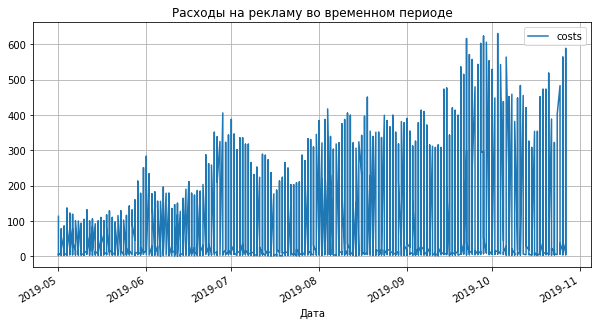

In [26]:
costs.plot(y = 'costs', 
           x = 'dt',
          kind = 'line',
          grid = True,
          figsize = (10, 5),
          title = 'Расходы на рекламу во временном периоде',
          xlabel = 'Дата');

Исходя из графика, можно заметить, что компания росла и с каждым новым месяцем вкладывала все большие и большие средства в самопродвижение

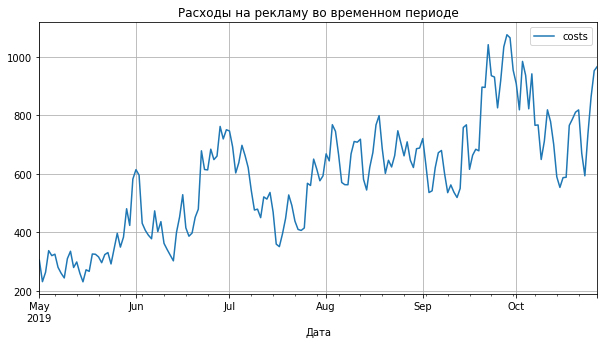

In [27]:
# ячейка ревьюера:
costs.groupby('dt').agg({'costs':'sum'}).reset_index().plot(y = 'costs', 
           x = 'dt',
          kind = 'line',
          grid = True,
          figsize = (10, 5),
          title = 'Расходы на рекламу во временном периоде',
          xlabel = 'Дата');

Теперь оценим распределение рекламы по источникам:

In [28]:
raspred = costs.pivot_table('costs', index = 'channel', aggfunc = 'sum')
raspred = raspred.sort_values(by = 'costs', ascending = False)
raspred = raspred.rename(columns={"costs": "Вложено в рекламу"})
raspred


,Вложено в рекламу
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


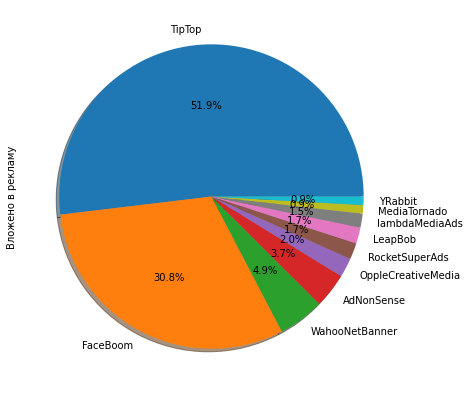

In [29]:
raspred.plot(x = 'channel', y = 'Вложено в рекламу', kind = 'pie',
            figsize = (13, 7),
            legend = False,
            autopct='%1.1f%%',
                   shadow=True, startangle=0);

In [30]:
raspred = raspred.rename(columns={"Вложено в рекламу": "costs"})

Львиную долю бюджета съедает TipTop (>50%) и FaceBoom (30.8%). Суммарно занимая более трех четвертей рекламного бюджета. Памятуя о выводах исследовательского анализа, можно заметить прямую связь между капиталовложениями в средство рекламы и отдачей

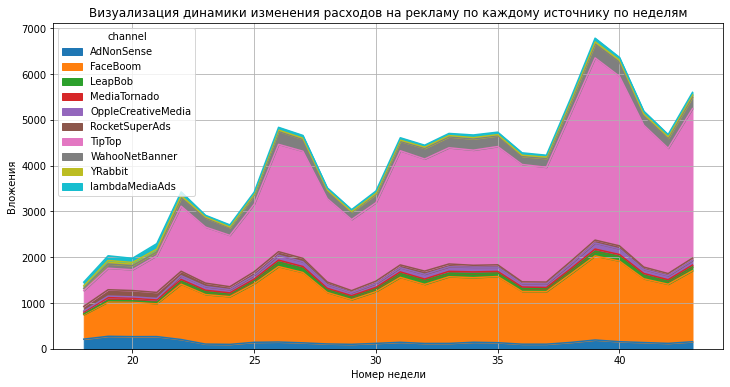

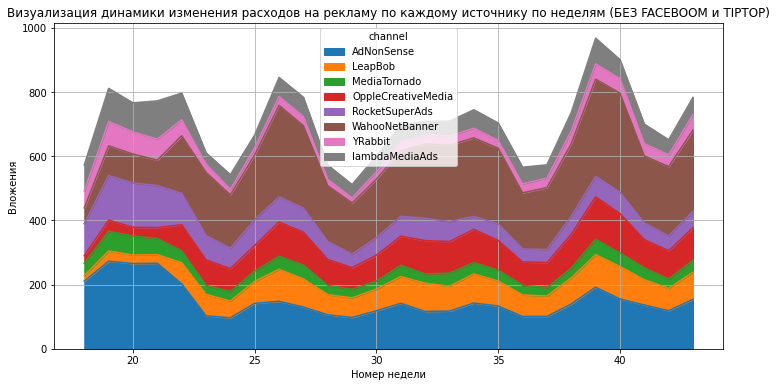

In [31]:
filtered_data = costs.pivot_table(
        index=costs['dt'].dt.week, columns='channel', values='costs', aggfunc='sum'
    )
ax = filtered_data.plot.area(                                             
           figsize=(12, 6),
           grid=True,
           label='Каналы',                       
           legend=True,
) 

plt.title('Визуализация динамики изменения расходов на рекламу по каждому источнику по неделям')
plt.xlabel('Номер недели')
plt.ylabel('Вложения')
plt.show()

filtered_data = costs[~costs['channel'].isin(['TipTop', 'FaceBoom'])].pivot_table(
        index=costs['dt'].dt.week, columns='channel', values='costs', aggfunc='sum'
    )
ax = filtered_data.plot.area(                                             
           figsize=(12, 6),
           grid=True,
           label='Каналы',                       
           legend=True,
) 

plt.title('Визуализация динамики изменения расходов на рекламу по каждому источнику по неделям (БЕЗ FACEBOOM и TIPTOP)')
plt.xlabel('Номер недели')
plt.ylabel('Вложения')
plt.show()

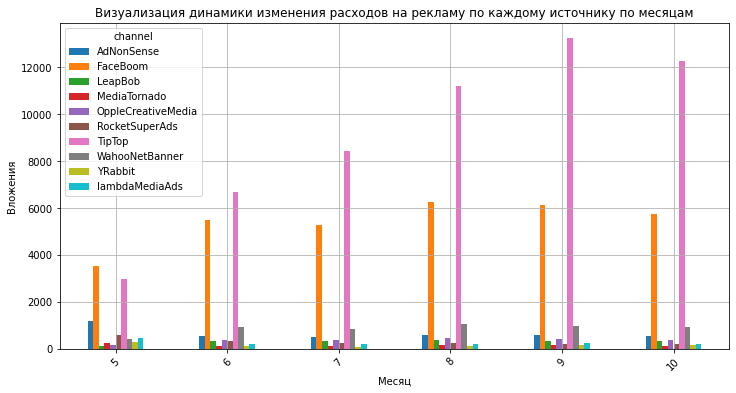

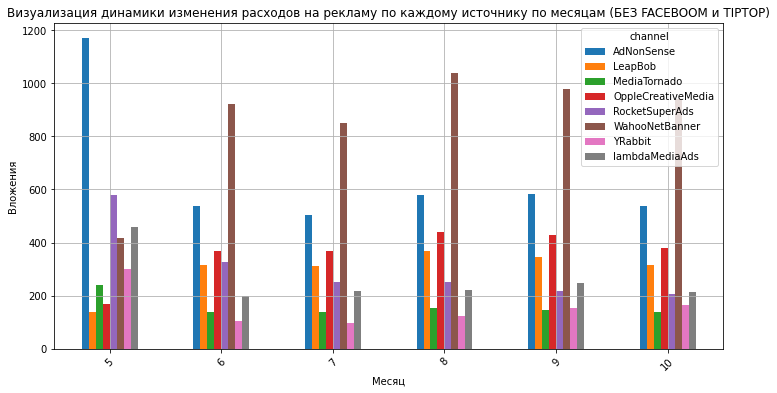

In [32]:
filtered_data = costs.pivot_table(
        index=costs['dt'].dt.month, columns='channel', values='costs', aggfunc='sum'
    )
ax = filtered_data.plot(                                             
           figsize=(12, 6),
           grid=True,
           rot=45,        
           label='Каналы',                       
           legend=True,
           kind = 'bar'
) 

plt.title('Визуализация динамики изменения расходов на рекламу по каждому источнику по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Вложения')
plt.show()

filtered_data = costs[~costs['channel'].isin(['TipTop', 'FaceBoom'])].pivot_table(
        index=costs['dt'].dt.month, columns='channel', values='costs', aggfunc='sum'
    )
ax = filtered_data.plot(                                             
           figsize=(12, 6),
           grid=True,
           rot=45,        
           label='Каналы',                       
           legend=True,
           kind = 'bar'
) 

plt.title('Визуализация динамики изменения расходов на рекламу по каждому источнику по месяцам (БЕЗ FACEBOOM и TIPTOP)')
plt.xlabel('Месяц')
plt.ylabel('Вложения')
plt.show()

Как можно заметить, стоимость рекламы в TipTop неукоснительно растет, в то время как остальные рекламные площадки не дорожают. Это может стать проблемой, поскольку на TipTop делается большая ставка в маркетинге компании.

#### Рассчитаем CAC по источникам рекламы

In [33]:
getcac = (profiles.groupby('channel').agg({'user_id': 'count', 'acquisition_cost': 'sum'}))

getcac['cac'] = (getcac['acquisition_cost'] / getcac['user_id'])

getcac.sort_values(by='cac', ascending=False)

,user_id,acquisition_cost,cac
channel,,,
TipTop,19561,54751.30,2.799003
FaceBoom,29144,32445.60,1.113286
AdNonSense,3880,3911.25,1.008054
lambdaMediaAds,2149,1557.60,0.724802
WahooNetBanner,8553,5151.00,0.602245
RocketSuperAds,4448,1833.00,0.412095
OppleCreativeMedia,8605,2151.25,0.250000
YRabbit,4312,944.22,0.218975
MediaTornado,4364,954.48,0.218717


Благодоря составленной таблице можно сделать вывод, что самое дорогое привлечение клиентов происходит через две самые популярные рекламные площадки заказчика - FaceBoom и TipTop. Возможно, стоит вложиться в что-то дешевое, как, например, LeapBob или MediaTornado?

### Оцените окупаемость рекламы

Используя графики LTV, ROI и CAC, создадим базу для последующего ответа на вопросы:
 - Окупается ли реклама, направленная на привлечение пользователей в целом?
 - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
 - Чем могут быть вызваны проблемы окупаемости?

In [34]:
horizon_days = 14
observation_date = datetime(2019, 11, 1).date()
paid_profiles = profiles.query('channel != "organic"')
not_paid_profiles = profiles.query('channel == "organic"')

Пользователей, пришедших из источника organic учитывать не станем. Естественно прибывшие пользователи будут мешать оценить рекламные показатели.

#### Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI

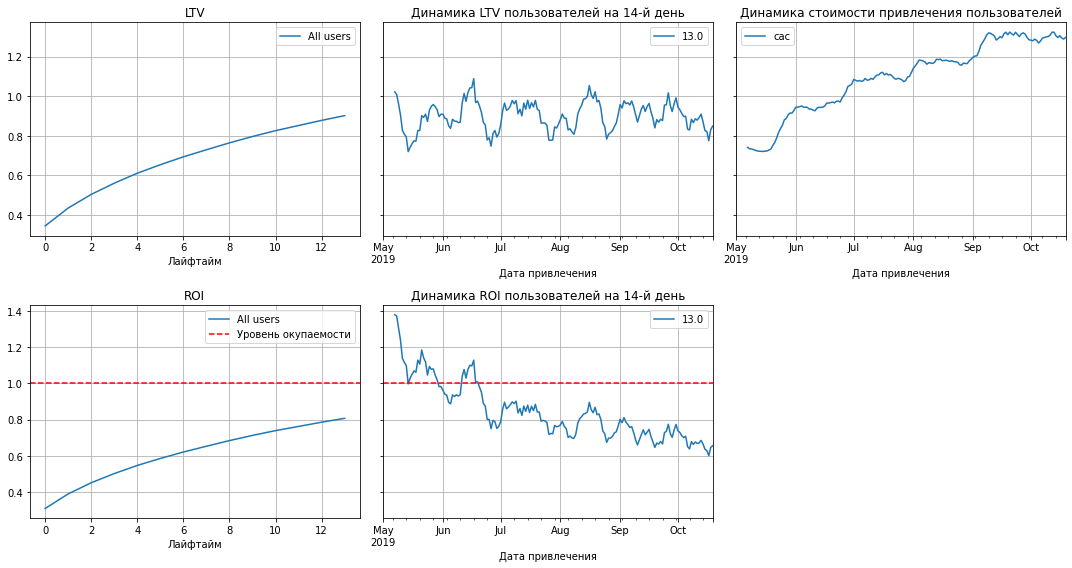

In [35]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

**Выводы:**

- ROI близок к 80% и к конце 2 реклама себя не окупила
- LTV имеет стабильную тенденцию
- С течением времени ROI падает. Ближе к середине лета он падает под черту окупаемости
- Корошо виден резкий количественный скачок финансирования рекламы в конце мая-июне 2019

#### Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучиим графики конверсии и удержания.

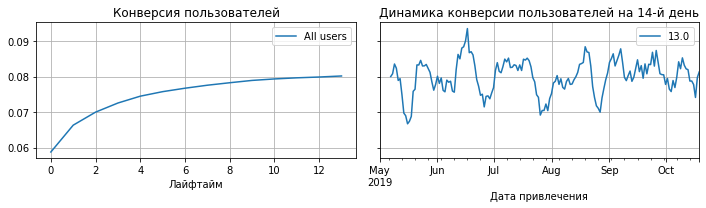

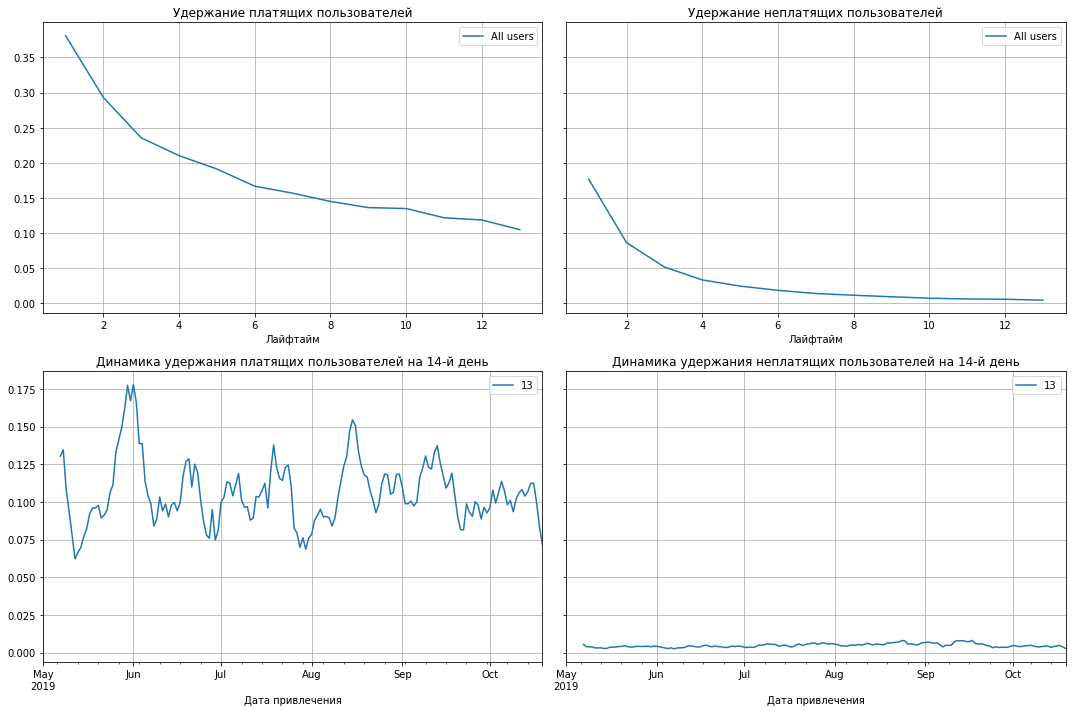

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    paid_profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

retention_raw, retention_grouped, retention_history = get_retention(
    paid_profiles, visits, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days)

Аномалий в показателях нет

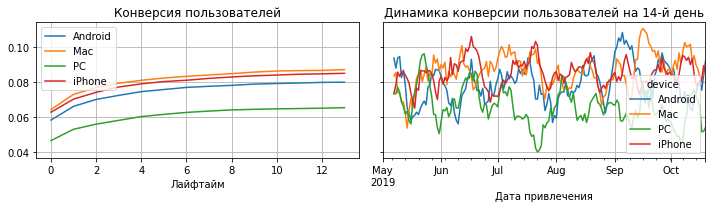

In [37]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

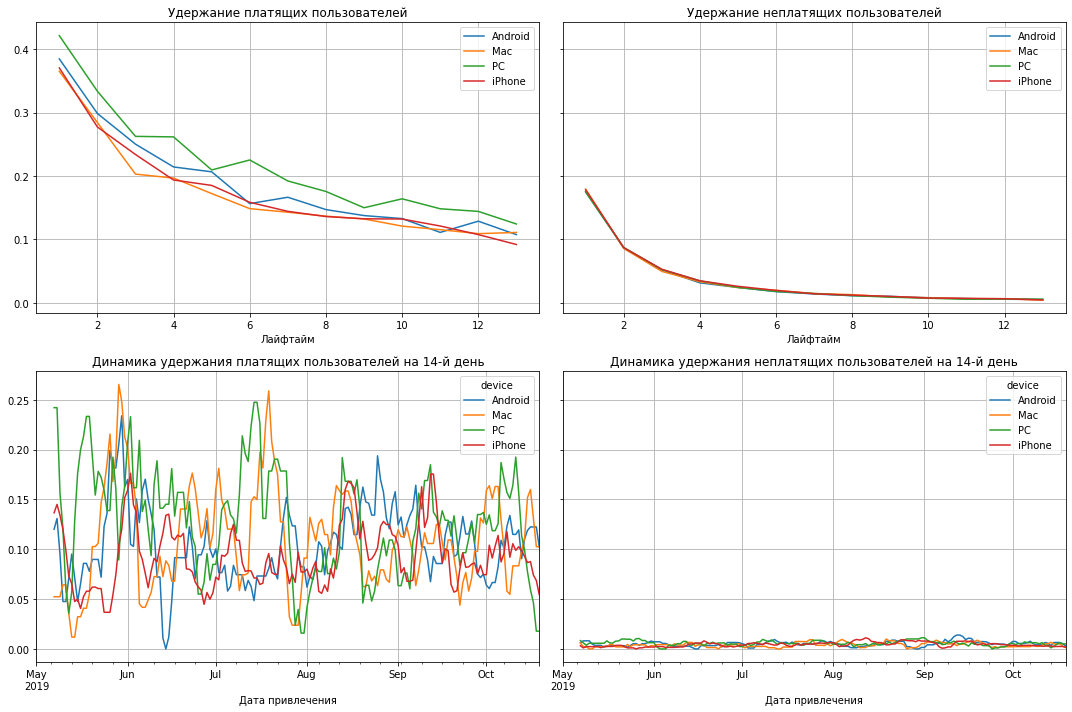

In [38]:
retention_raw, retention_grouped, retention_history = get_retention(
    paid_profiles, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей для всех устройств примерно равно и убывает, стремясь к 0. PC имеют самую низкую конверсию и самое долгое удержание. Пользователи Apple имеют удержание ниже чем платящие пользователи иных платформ

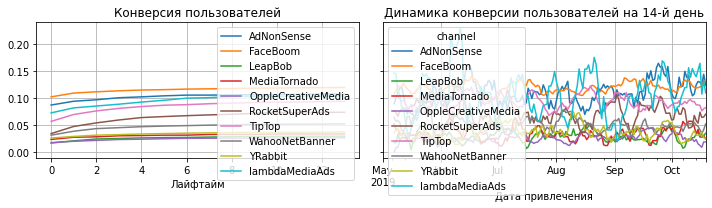

In [39]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

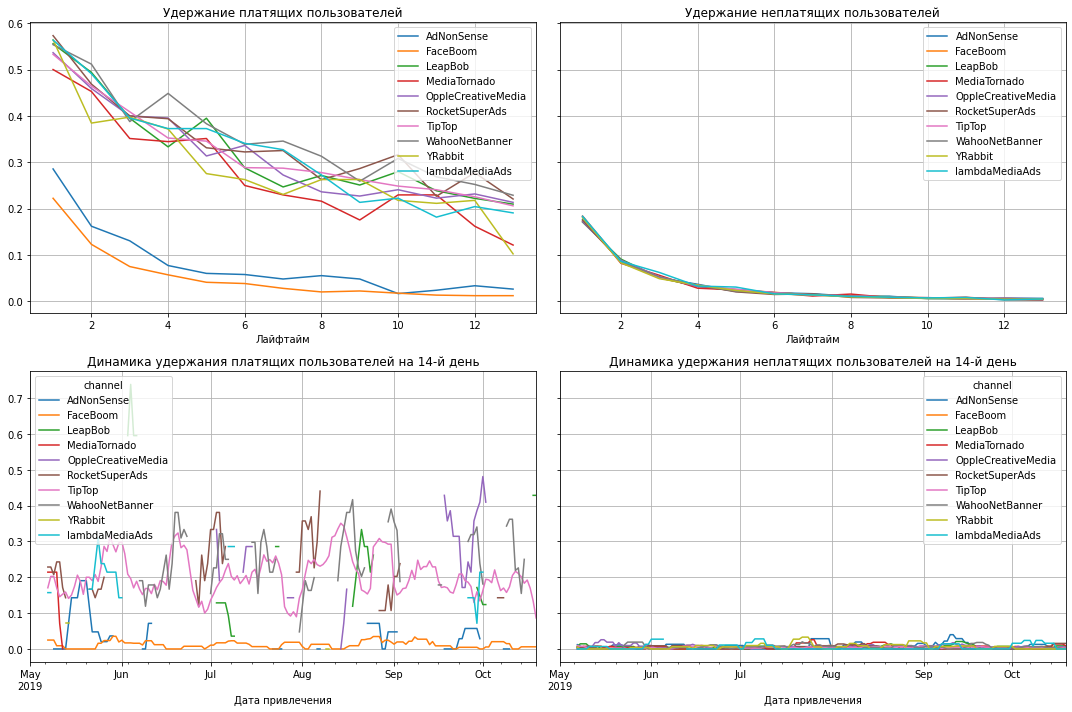

In [40]:
retention_raw, retention_grouped, retention_history = get_retention(
    paid_profiles, visits, observation_date, horizon_days, dimensions=['channel']
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Выводы:**

- Аномалий в общих данных нет
- Пользователи Apple чаще конвертируются в платных пользователей
- AdNonSense и FaceBoom очень плохо справляются с удержаним платящих пользователей. Оно на уровне неплатящих пользователей.
- Учитывая, что AdNonSense и FaceBoom обеспечивают наилучшую конверсию пользователей в платящих пользователей, возможно стоит изменить локальную рекламную стратегию на данных площадках

#### Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

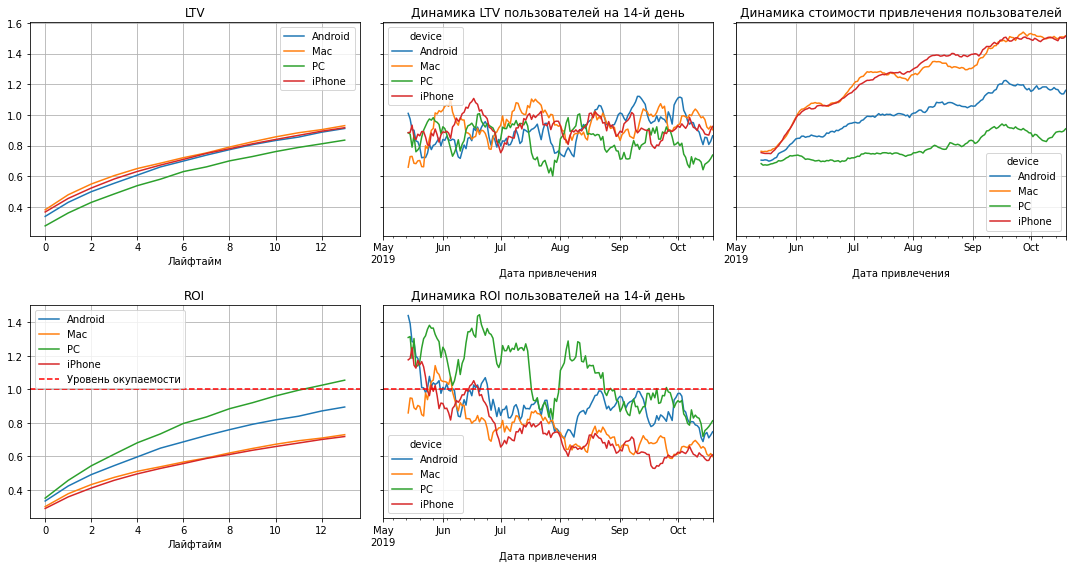

In [41]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['device']
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Выводы:**

- Среди всех платформ окупился лишь PC
- Пользователи PC приносят наименьший доход компании за все время пользования её продуктом
- Пользователи PC дешевле всего привлекаются. Дороже всех - пользователи устройств Apple
- Резкие изменения в любом из основных параметров отсутствуют. Проблема не связана с устройством.

#### Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

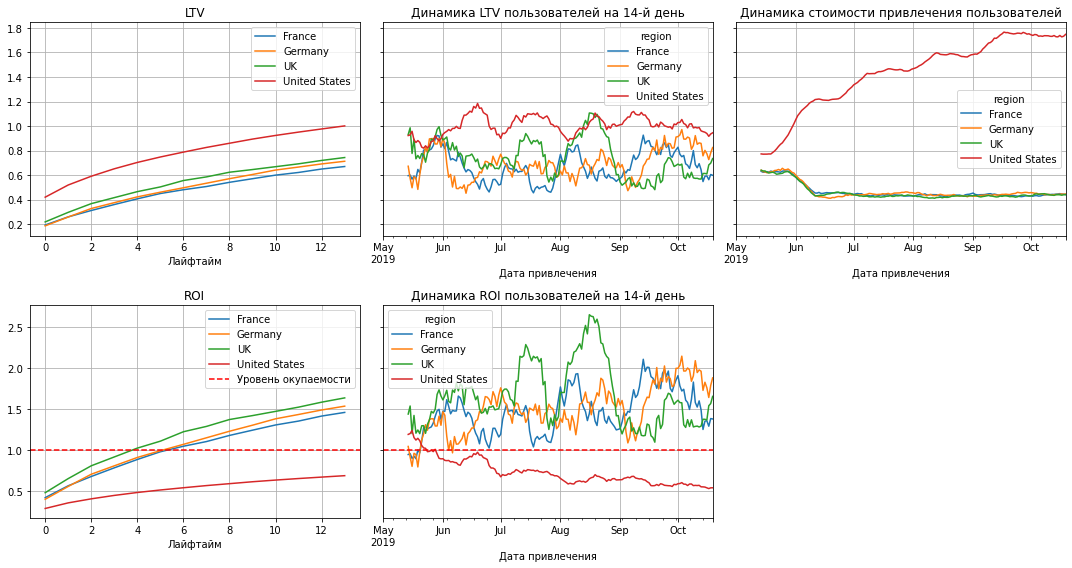

In [42]:
# считаем LTV и ROI по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['region']
)

# построим график со сглаживанием в 14 дней
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Выводы:**

- Американцы не окупают своими большими тратами огромные затраты на их привлечение
- Американцы имеют наименьший показатель ROI к 14 дню. Единственная страна, которая не может себя окупить.
- С течением времени привлекать американскую аудиторию становится все дороже и дороже. Кратно дороже, если сравнивать с Европой

#### Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

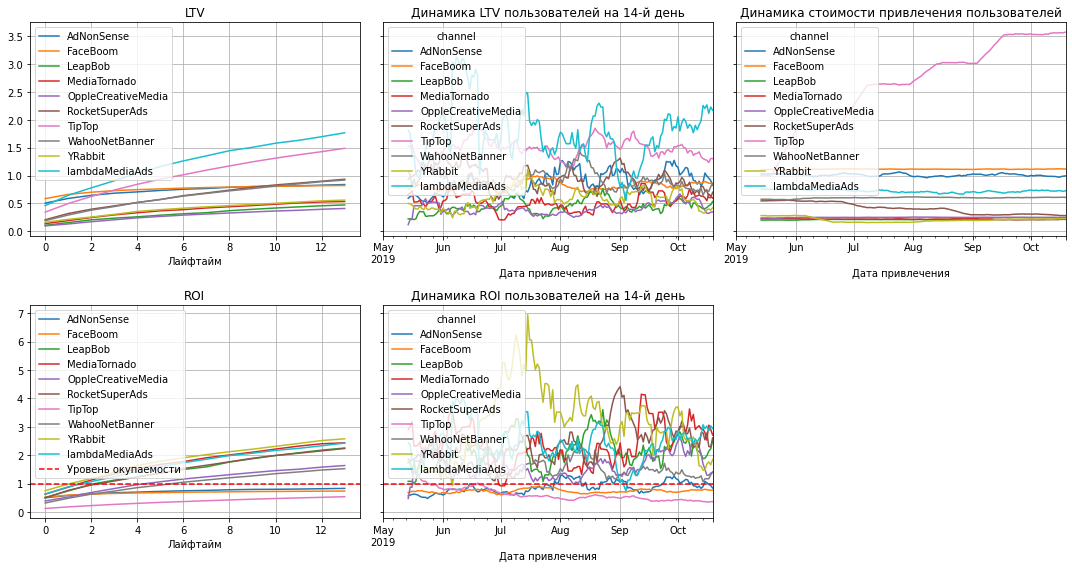

In [43]:
# считаем LTV и ROI по странам
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    paid_profiles, orders, observation_date, horizon_days, dimensions=['channel']
)

# построим график со сглаживанием в 14 дней
plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

**Выводы:**

- FaceBoom, TipTop и AdNonSense не окупают себя. Требуется искать альтернативные каналы для рекламы.
- Наибольший LTV у LambdaMediaAds

# Общий вывод

По результатам проделанного исследования можно заключить следующее:

- Реклама из трех основных источников, которые занимают >3/4 рекламного бюджета себя не окупает. 
    * FaceBoom, AdNonSense имеют слишком маленькое привлечение относительно своей стоимости
    * TipTop, не смотря на свои хорошие показатели, становится все дороже и дороже. Уже сейчас это является проблемой, поэтому прогноз на будущее негативный
- Пользователи из США приносят компании наибольшие доходы. Однако, эти доходы даже близко не могут компенсировать расходы на привлечение клиентов.

# Рекомендации бизнесу

- Снизить затраты на рекламу через FaceBoom и AdNonSense в Американсом регионе. Перераспределить эти затраты в пользу площадки **YRabbit**. Она показывает хорошие результаты на рынке Америки.
- Помимо YRabbit перераспределить средства в полььзу
    * lambdaMediaAds
    * WahooNetBanner
- Пересмотреть актуальность вложений в рекламу через TipTop. Рост стоимости размещения там вскоре может привести к ещё большим убыткам от рекламы ввиду  

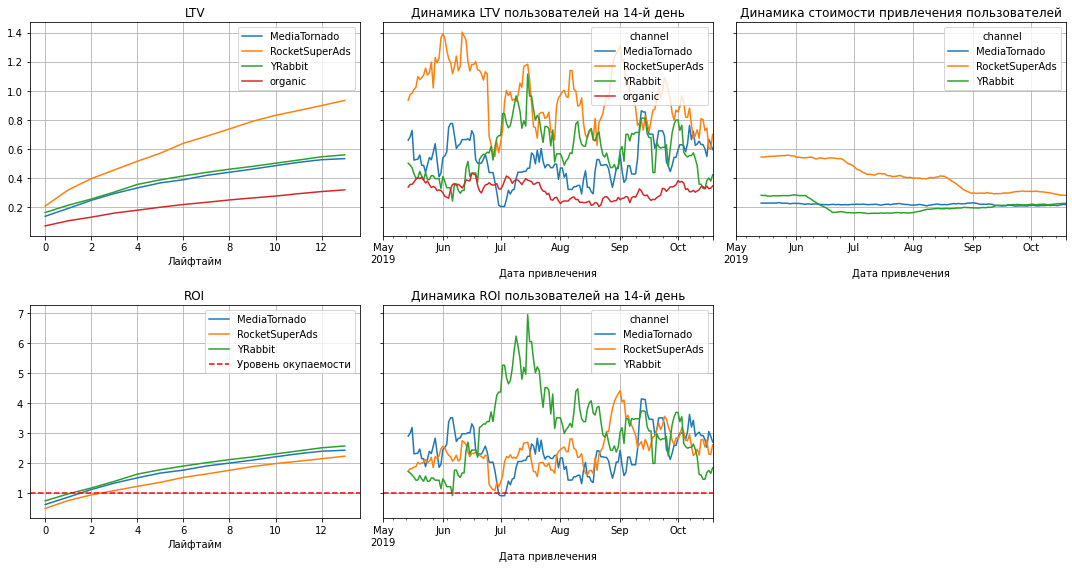

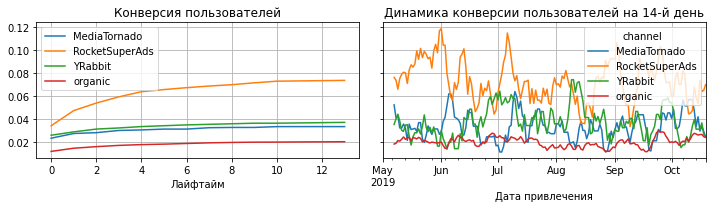

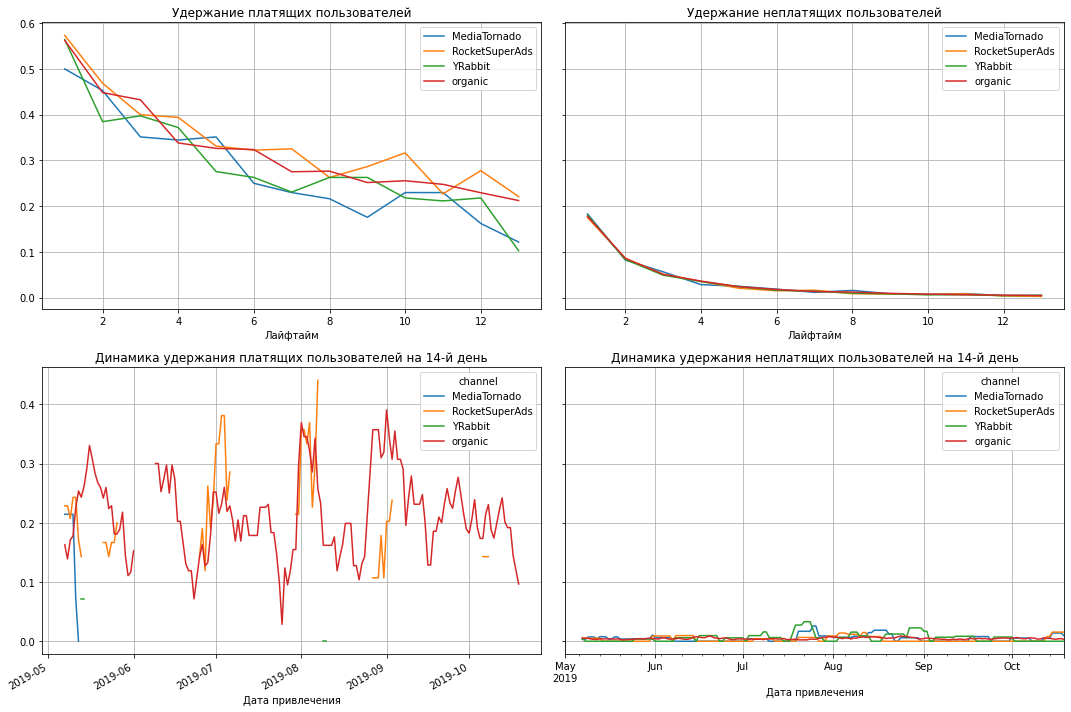

In [44]:
# Ячейка ревьюера:

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('region == "United States" and channel not in ["TipTop","FaceBoom"]'), orders, observation_date, 14, dimensions=dimensions)
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('region == "United States" and channel not in ["TipTop","FaceBoom"]'), orders, observation_date, 14, dimensions=dimensions)
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('region == "United States" and channel not in ["TipTop","FaceBoom"]'), visits, observation_date, 14, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14, window=14) 
plot_conversion(conversion_grouped, conversion_history, 14)
plot_retention(retention_grouped, retention_history, 14)